# Homework 1: Autoregressive models

## Task 1: Theory (4pt)

In [1]:
%matplotlib inline

### Problem 1: Sampling from KDE (1pt)

Let $\hat{p}_h(x) = \frac{1}{n h^d} \sum\limits_{i = 1}^{n} K\left(\frac{x - X_i}{h}\right)$ is the Kernel Density Estimator (see seminar 1) of a density $p_{\pi}$, where $X_1, \dots, X_n \sim p_{\pi}$, $X_i \in \mathbb{R}^d$.

Consider the following sampling scheme:
>
>1. Choose random number $k$ uniformly from the collection of numbers $\{1, 2, \dots, n\}$.
>
>2. Sample the random variable $\tilde{X}$ from the kernel $\frac{1}{h^d} K\left(\frac{x - X_k}{h}\right)$.
>

Prove, that $\tilde{X}$ is distributed according to $\hat{p}_h(x)$, i.e. the scheme above is the correct sampling scheme for $\hat{p}_h(x)$.

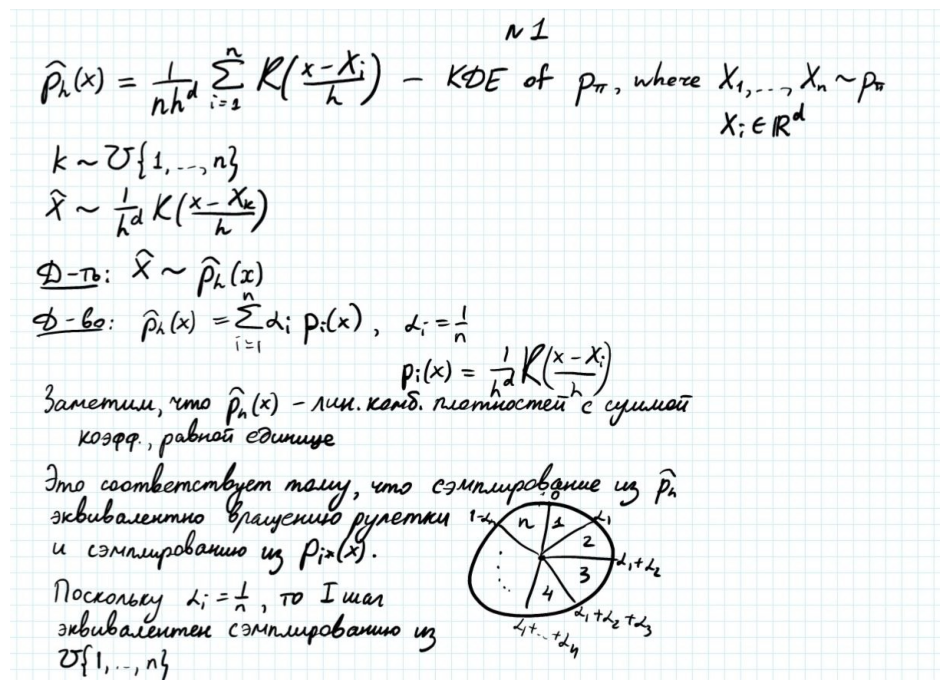

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread("task_1.jpg")
plt.figure(figsize=(12, 10))
plt.imshow(image)
plt.axis(False)
plt.show()

### Problem 2: $\alpha$-divergence (1pt)

In the course, we will meet different divergences (not only $KL$). So let's get acquainted with the class of $\alpha$-divergences:
$$
    D_{\alpha}(p || q) = \frac{4}{1 - \alpha^2} \left( 1 - \int p(x)^{\frac{1 + \alpha}{2}}q(x)^{\frac{1 - \alpha}{2}}dx\right).
$$
For each $\alpha \in [-\infty; +\infty]$ the function $D_{\alpha} (p || q)$ is a measure of the similarity between two distributions. $D_{\alpha} (p || q)$ has different properties for different $\alpha$.

Prove that for $\alpha \rightarrow 1$ the divergence $D_{\alpha}(p || q) \rightarrow KL(p || q)$, and for $\alpha \rightarrow -1$ the divergence $D_{\alpha}(p || q) \rightarrow KL(q || p)$.

**Hint:** use the fact that $t^\varepsilon = \exp(\varepsilon \cdot \ln t) = 1 + \varepsilon \cdot \ln t + O(\varepsilon^2)$.

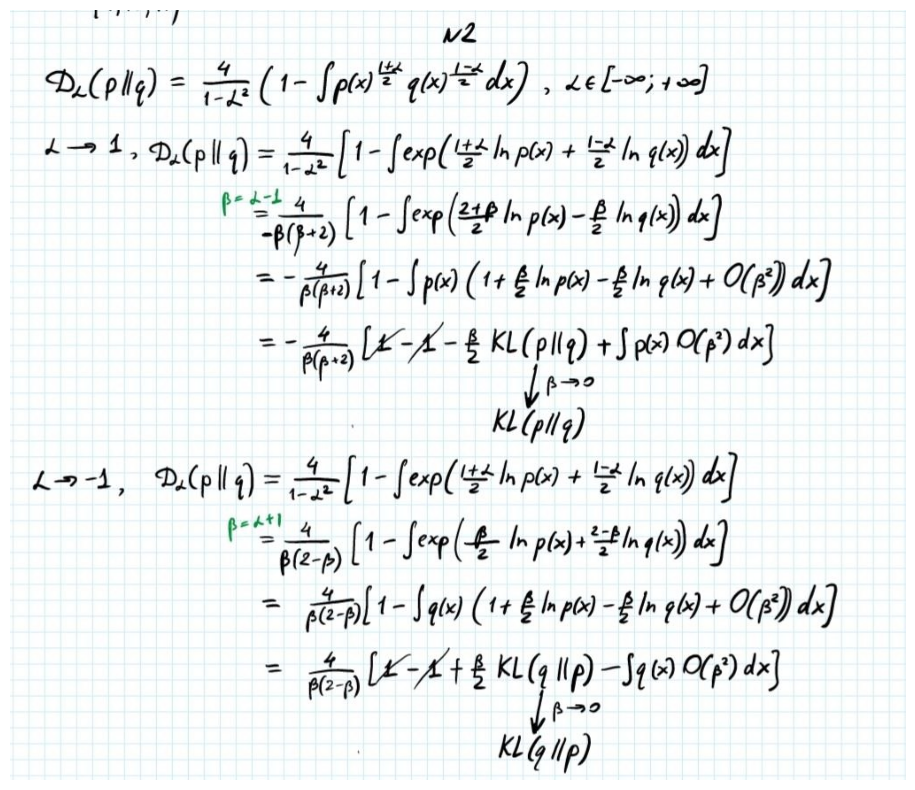

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread("task_2.jpg")
plt.figure(figsize=(12, 10))
plt.imshow(image)
plt.axis(False)
plt.show()

### Problem 3: Curse of dimensionality (2pt)

The main problem of generative modelling is the curse of dimensionality. Let try to get some intuition about it.

Let consider a sphere of radius $r = 1$ in a space of $m$ dimensions. Our goal is to find the fraction of the volume of the sphere that lies between radius $r = 1 - \epsilon$ and $r = 1$. Our geometric intuition is that this fraction is small. But the magic happens with $m$ goes to infinity.

1. Find the expression of the volume of a shpere of radius $r$ in $m$ dimensions.

2. Find the required fraction.

3. Prove that, for large $m$, the fraction tends to 1 even for small values of $\epsilon$.

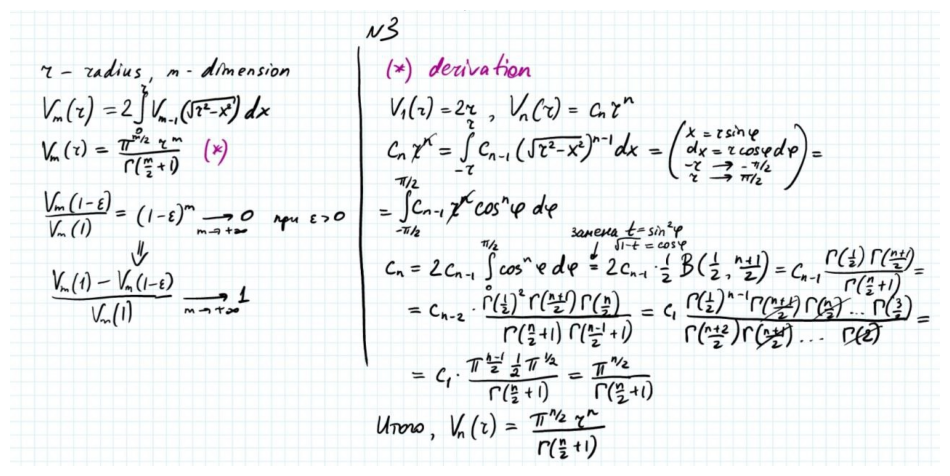

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread("task_3.jpg")
plt.figure(figsize=(12, 10))
plt.imshow(image)
plt.axis(False)
plt.show()

Now it time to move on to practical part of homework.

In our course we have a small util [package](https://github.com/r-isachenko/2022-DGM-Ozon-course/blob/main/homeworks/dgm_utils/utils.py) with some usefull functions for loading and visualizing the images and training plots. In each homework there is a cell with installing this package. Please read carefully what functions we have in this package. It could help you to solve the tasks.

In [ ]:
REPO_NAME = "2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Cloning into '2023-DGM-MIPT-course'...
remote: Enumerating objects: 443, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 443 (delta 25), reused 42 (delta 22), pack-reused 391
Receiving objects: 100% (443/443), 207.26 MiB | 16.47 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Updating files: 100% (268/268), done.
Processing ./2023-DGM-MIPT-course/homeworks
  Preparing metadata (setup.py) ... done
  Created wheel for dgm-utils: filename=dgm_utils-0.1.0-py3-none-any.whl size=4010 sha256=7974d2bfa4aa0501682174c06ac35c28a843ea5de89fdfd98a4c792be2e37c86
  Stored in directory: /tmp/pip-ephem-wheel-cache-oxlv0ww7/wheels/d7/24/b0/17b69ee697654689a9a78e4d6d52c72d6c09e07ac2e47017ad
Successfully built dgm-utils


In [ ]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_dataset

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()

## Task 2: PixelCNN receptive field and autocompletion on MNIST (4pt)

[PixelCNN](https://arxiv.org/abs/1601.06759) model uses masked causal convoultions on images, we have discussed this model on the lecture 1 and seminar 2.

The PixelCNN model is a powerful model. But the model has drawbacks.

1. The model is sequential and sampling is really slow (it is a drawback of all AR models).

2. The receptive field of the model is not so large. Even if the model is well-trained, the samples do not have long-range history.

We will analyze these drawbacks.

But first of all we need to train this model.

100%|██████████| 9912422/9912422 [00:00<00:00, 183669939.81it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 118296576.00it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 78645084.00it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3699850.22it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



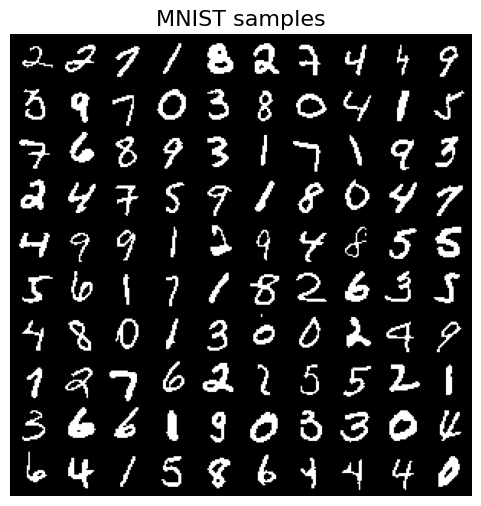

In [ ]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data, "MNIST samples")

Masked Convolution Layer is the basic building block of PixelCNN model. Look carefully at this code.

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, mask_type: str, in_channels: int, out_channels: int, kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)

    def create_mask(self, mask_type: str) -> None:
        # try to understand the logic about mask_type
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

[Layer Normalization](https://arxiv.org/abs/1607.06450) helps to stabilize training process.

In [ ]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters: int) -> None:
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

Now we are ready to define the main PixelCNN model.

In [ ]:
class PixelCNN(nn.Module):
    def __init__(
        self,
        input_shape: tuple[int],
        n_filters: int = 64,
        kernel_size: int = 7,
        n_layers: int = 5,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__()
        self.input_shape = input_shape

        # we apply the sequence of MaskedConv2d -> LayerNorm (it is optional) -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2
        model = [MaskedConv2d("A", 1, n_filters, kernel_size=kernel_size)]

        for _ in range(n_layers):
            if use_layer_norm:
                model.append(LayerNorm(n_filters))
            model.append(nn.ReLU())
            model.append(
                MaskedConv2d("B", n_filters, n_filters, kernel_size=kernel_size)
            )

        model.extend(
            [
                nn.ReLU(),
                MaskedConv2d("B", in_channels=n_filters, out_channels=2, kernel_size=1),
            ]
        )

        self.net = nn.Sequential(*model)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        out = (x - 0.5) / 0.5
        out = self.net(out)
        return out.view(batch_size, 2, 1, *self.input_shape)

    def loss(self, x: torch.Tensor) -> dict:
        # our loss is just cross entropy
        total_loss = F.cross_entropy(self(x), x.long())
        return {"total_loss": total_loss}

    @torch.no_grad()
    def sample(self, n: int) -> np.ndarray:
        # read carefully the sampling process
        # here you see the sequential process of sampling
        samples = torch.zeros(n, 1, *self.input_shape).to(self.device)
        for r in range(self.input_shape[0]):
            for c in range(self.input_shape[1]):
                logits = self(samples)[:, :, :, r, c]
                probs = F.softmax(logits, dim=1).squeeze(-1)
                samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(
                    -1
                )
        return samples.cpu().numpy()

In [ ]:
# ====
# your code
# choose these parameters
# (here you could see the tips for the hyperparameters, they could help you,
# but sometimes you could find more appropriate values,
# experiment with them.)
EPOCHS = 5      # > 5
BATCH_SIZE = 64  # any adequate value
LR = 1e-3          # < 1e-2
N_LAYERS = 5    # < 10
N_FILTERS = 32   # < 128
USE_LAYER_NORM = True
# ====

model = PixelCNN(
    input_shape=(28, 28),
    n_filters=N_FILTERS,
    kernel_size=5,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

loss = model.loss(torch.zeros(1, 1, 28, 28))
assert isinstance(loss, dict)
assert "total_loss" in loss

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

test_loss = test_losses["total_loss"][-1]
print(
    f"Test loss: {test_loss:.2f}",
)
assert test_loss < 0.10

  0%|          | 0/5 [00:00<?, ?it/s]

Test loss: 0.08


Even if the test loss is bigger than the value in assert, try to visualize train/test curves, it could find you to find the bug.

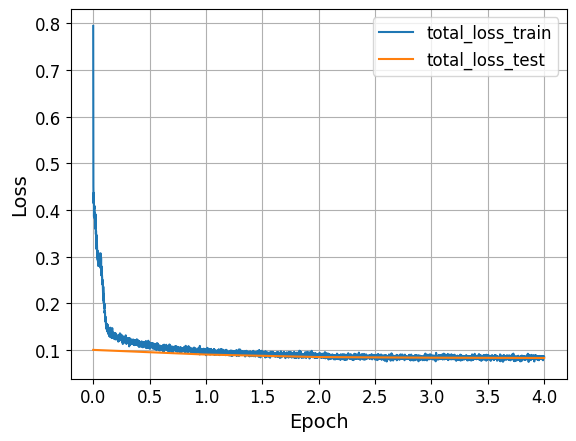

In [ ]:
plot_training_curves(train_losses, test_losses)

Now we sample the new images from the model. Notice that the sampling from the autoregressive model is slow, because it is a sequential process.

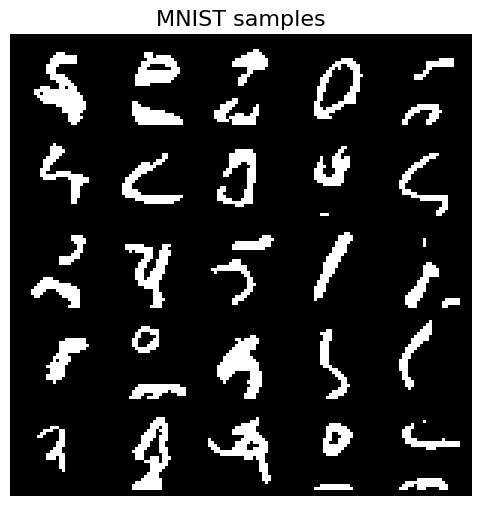

In [ ]:
samples = model.sample(25)
show_samples(samples, title="MNIST samples", nrow=5)

### Receptive field

Let try to visualize the receptive field of the model.

We should see that the receptive field grows with increasing number of convolutional layers.

The receptive field can be empirically measured by backpropagating an arbitrary loss for the output features of a specific pixel with respect to the input. We implement this idea below, and visualize the receptive field below.

In [ ]:
def plot_receptive_field(model: object, model_name: str) -> None:
    # ====
    # your code
    # 1) create tensor with zeros and set required_grad to True.
    inp = torch.zeros((1, 1, *model.input_shape), requires_grad=True).to(model.device)

    # 2) apply model to the tensor
    outp = model(inp)

    # 3) apply backward() to the center pixel of model output
    x_center, y_center = model.input_shape[0] // 2, model.input_shape[1] // 2
    loss = outp[0, 0, 0, x_center, y_center]
    loss.backward(retain_graph=True)

    # 4) take the gradient with respect to input
    grad = torch.autograd.grad(outputs=loss, inputs=inp, retain_graph=True)
    grad_map = grad[0][0, 0].detach().cpu().numpy()

    # 5) binary receptive field is an indicator map in which we stay 1's if gradient more than 1e-8
    binary_map = (grad_map > 1e-8).astype(float)

    # 6) weighted receptive field is the normalized gradient (values lies in [0, 1])x
    weighted_map = grad_map / np.linalg.norm(grad_map)

    # ====

    # we stack the maps to get RGB image
    binary_map = np.stack([binary_map, binary_map, binary_map], axis=-1)
    weighted_map = np.stack([weighted_map, weighted_map, weighted_map], axis=-1)

    # center point will be red
    binary_map[x_center, y_center] = [1, 0, 0]
    weighted_map[x_center, y_center] = [1, 0, 0]

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(weighted_map, vmin=0.0, vmax=1.0)
    ax[1].imshow(binary_map, vmin=0.0, vmax=1.0)

    ax[0].set_title(f"Weighted receptive field for {model_name}")
    ax[1].set_title(f"Binary receptive field for {model_name}")

    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()

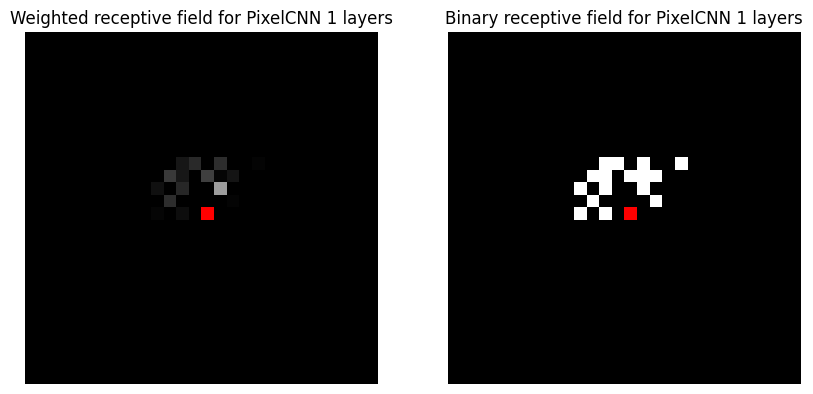

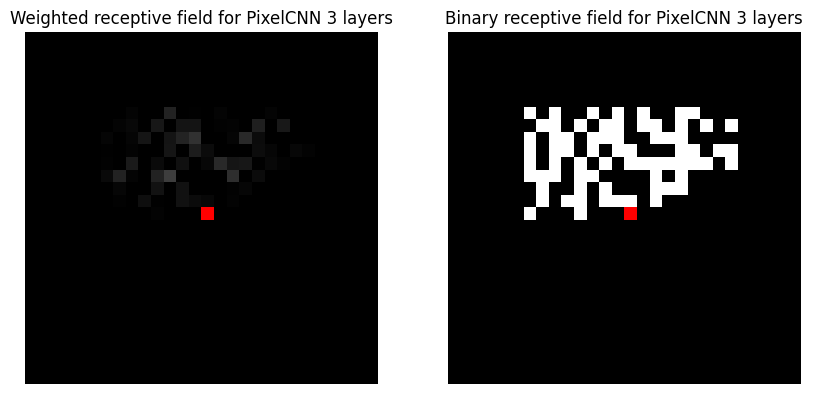

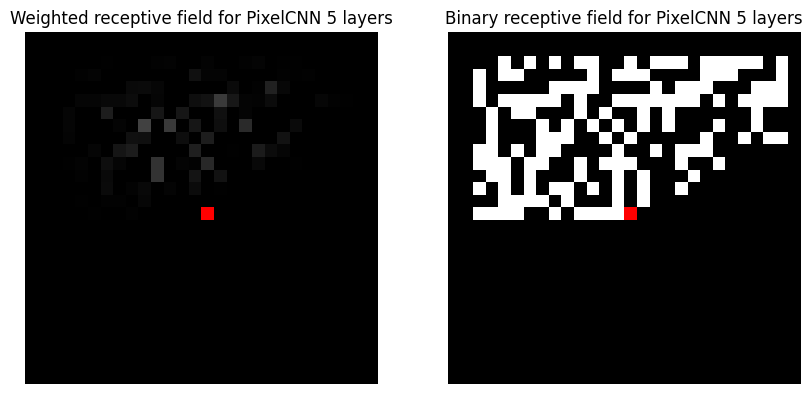

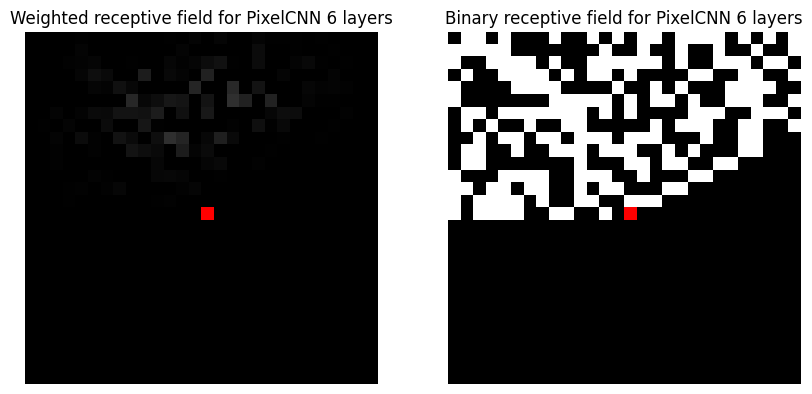

In [ ]:
for n_layers in [1, 3, 5, 6]:
    model = PixelCNN(
        input_shape=(28, 28),
        n_filters=32,
        kernel_size=5,
        n_layers=n_layers,
        use_layer_norm=True,
    )
    if USE_CUDA:
        model = model.cuda()
    plot_receptive_field(model, model_name=f"PixelCNN {n_layers} layers")

You have to see that PixelCNN has strange blind spot in binary receptive field plot on the right side. This is a known issue of PixelCNN model. Please, try to understand why it happens.

One way to solve this problem is a [GatedPixelCNN](https://arxiv.org/pdf/1606.05328.pdf) model (see paper, if you are interested in).

### Image autocompletion

One more feature of autoregressive model that we try is auto-completing an image. As autoregressive models predict pixels one by one, we can set the first pixels to predefined values and check how the model completes the image.

For implementing this, we just need to skip the iterations in the sampling loop that already have a value unequals to -1.
We redefine the sample method in our PixelCNN class to allow it to take the init of the sample.

In [ ]:
class PixelCNNAutoComplete(PixelCNN):
    @torch.no_grad()
    def sample(self, n: int, init: Optional[torch.Tensor] = None) -> np.ndarray:
        # ====
        # this method almost the same as the method of the base PixelCNN model
        # but now if init is given, this tensor will be used as a starting image.
        # The pixels to fill should be -1 in the input tensor.
        if init is not None:
            samples = init.clone().to(self.device)
        else:
            samples = torch.zeros(n, 1, *self.input_shape).to(self.device)

        for r in range(self.input_shape[0]):
            for c in range(self.input_shape[1]):
                if samples[0, 0, r, c] != -1:
                    continue

                logits = self(samples)[:, :, :, r, c]
                probs = F.softmax(logits, dim=1).squeeze(-1)
                sampled_pixel = torch.multinomial(probs, num_samples=1).squeeze(-1)

                samples[:, 0, r, c] = sampled_pixel

        return samples.cpu().numpy()

You have to repeat the model training.

In [ ]:
model = PixelCNNAutoComplete(
    input_shape=(28, 28),
    n_filters=N_FILTERS,
    kernel_size=5,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

assert test_losses["total_loss"][-1] < 0.10

  0%|          | 0/5 [00:00<?, ?it/s]

We randomly take images from the training set, mask the lower half of the image (set -1's), and let the model autocomplete it. We do this several times for each image to see the diversity of samples.

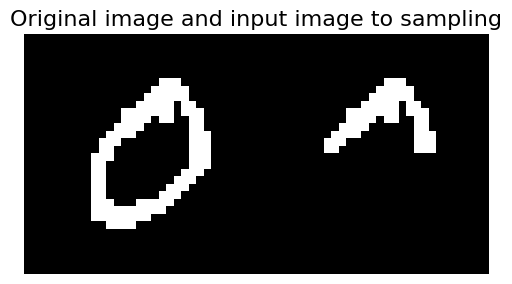

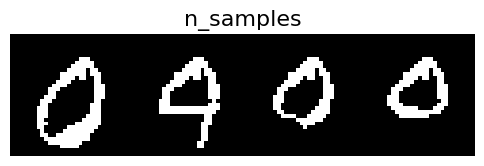

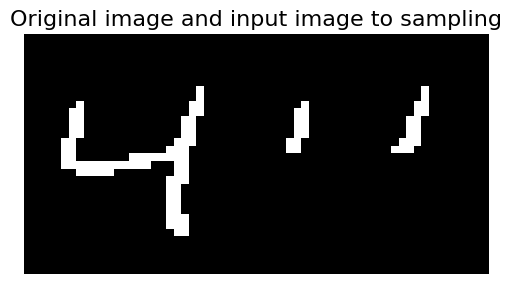

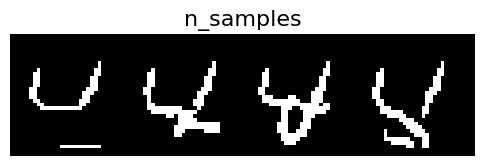

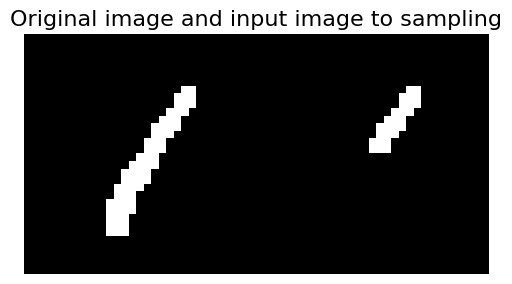

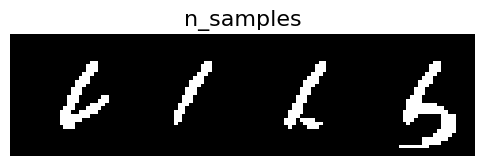

In [ ]:
def autocomplete_image(image: np.ndarray, model: object, n_samples: int) -> None:
    # Remove lower half of the image
    image_init = image.copy()
    image_init[:, image.shape[1] // 2 :, :] = -1
    samples = np.stack([image, np.maximum(image_init, 0)])
    show_samples(samples, title="Original image and input image to sampling", nrow=2)
    # Generate completions
    image_init = torch.tensor(image_init)
    image_init = (
        image_init.unsqueeze(dim=0).expand(n_samples, -1, -1, -1).to(model.device)
    )
    img_generated = model.sample(n_samples, image_init)
    show_samples(img_generated, title="n_samples", nrow=4)


for i in range(1, 4):
    autocomplete_image(train_data[i], model, n_samples=4)

## Task 3: ImageGPT on MNIST (5pt)

In this task you will try to implement the Image Transformer net for an autoregressive generation MNIST images. See the [blog](https://openai.com/blog/image-gpt/) and [paper](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) for details.

### Architecture

Let describe the model architecture.

Image Transformer consists of $L$ identical blocks similar to GPT-2 decoder blocks. These blocks are applied sequentially. The $l$th block receives a tensor $\mathbf{h}^l$ with shape (batch_size, pixel_num, emb_dim) where pixel_num is a total number of pixels $(28*28)$ and emb_dim is a hyperparameter for the size of the embeddings.

The tensor is transformed as follows:
$$
\begin{align}
    \mathbf{n}^l &= \text{layer_norm}(\mathbf{h}^l), \\
    \mathbf{a}^l &= \mathbf{h}^l + \text{multihead_attention}(\mathbf{n}^l), \\
    \mathbf{h}^{l+1} &= \mathbf{a}^l + \text{MLP}(\text{layer_norm}(a^l)). \\
\end{align}
$$

We have already used LayerNorm in PixelCNN, so we do not discuss it here.

Each head of the multihead attention computes an embedding
$$
    \text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}}) \mathbf{V},
$$
where $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ - query/key/value matrices obtained using Linear projection of $\mathbf{h}^l$.
Then embeddings across all heads are stacked and followed by a linear layer.

We will use just 2 Linear layers with ReLU activation for MLP.

Embedding $h^1$ (our first embedding) is a sum of a token embedding of the input batch and learned positional embedding.

After the last block we will apply a LayerNorm and a lLnear layer to obtain logits of size (batch_size, pixel_num, 2)
$$
\begin{align*}
  n^L &= \text{layer norm}(h^L) \\
  \text{logits} &= \text{linear}(n^L)
\end{align*}
$$

### Autoregressive property
To make the model autoregressive we will introduce the following changes:

1. We will apply the upper triangular mask to the matrix of attention logits ($\mathbf{Q}\mathbf{K}^T$). Masked values are made close to minus infinity so they will turn zero after softmax.
2. During training we will add "start of sequence" token to the input tensor and pop the last pixel.

Note: we will use raster order to identify which pixels come first (as we have done in PixelCNN). For each pixel the predicted probabality is conditioned on all the previous pixels.

Let start with the multihead attention block.

In [ ]:
class MultiheadAttention(nn.MultiheadAttention):
    def __init__(self, embed_dim: int, num_heads: int) -> None:
        super().__init__(embed_dim, num_heads)

    def get_attention_mask(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # define attention mask, it should contain
        # - zeros under and on the main diagonal
        # - minus Inf above the main diagonal
        ones_arr = torch.full((x.shape[0], x.shape[0]), -torch.inf).to(x.device)
        attention_mask = torch.triu(ones_arr, diagonal=1)

        # ====
        return attention_mask

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_mask = self.get_attention_mask(x)
        return super().forward(x, x, x, attn_mask=attn_mask, need_weights=False)[0]


def test_attention_mask() -> None:
    x = torch.zeros(2, 768, 16)  # (batch_size, pixel_num, emb_dim)
    mask = np.array([[0.0, -np.inf], [0.0, 0.0]])
    layer = MultiheadAttention(16, 8)
    attention_mask = layer.get_attention_mask(x)
    assert attention_mask.size() == (x.size(0), x.size(0))
    assert np.allclose(attention_mask.numpy(), mask)
    out = layer(x)
    assert x.size() == out.size()


test_attention_mask()

Now we will define the base decoder block.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int) -> None:
        """
        :param embed_dim: dimension of embedding space
        :param num_heads: number of attention heads
        """
        super().__init__()
        assert embed_dim % num_heads == 0

        # ====
        # define multihead attention (https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
        # define LayerNorm (https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)
        # (here we do not use previous class for LayerNorm because we do not need to change order of tensor dimensions)
        # define MLP - 2 linear layers with ReLU
        # (You could choose the latent dimensionality of MLP as you like. For example, double the embed_dim)
        self.attention = MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # here you have to implement formulas that described above
        layer_norm_outp = self.norm1(x)
        attn_output = x + self.attention(layer_norm_outp)
        outp = attn_output + self.mlp(self.norm2(attn_output))
        # ====
        return outp


def test_decoder_block() -> None:
    block = DecoderBlock(embed_dim=12, num_heads=4)
    x = torch.zeros(4, 28, 12)
    assert x.shape == block(x).shape


test_decoder_block()

In [ ]:
class ImageGPT(nn.Module):
    def __init__(
        self, input_shape: tuple[int], embed_dim: int, num_heads: int, num_layers: int
    ) -> None:
        super().__init__()

        self.embed_dim = embed_dim
        self.input_shape = input_shape
        self.criterion = nn.BCEWithLogitsLoss()

        # "start of sequence" token (we initialize it from Normal distribution)
        self.sos = torch.nn.Parameter(torch.zeros(embed_dim))
        nn.init.normal_(self.sos)

        # ====
        # 1) define token_embeddings
        #    (we will have 2 embeddings in total, because our images are binary)
        # 2) define position_embeddings (they will be learnable)
        self.token_embeddings = nn.Embedding(2, embed_dim)
        self.position_embeddings = nn.Parameter(torch.zeros(input_shape[0] * input_shape[1], embed_dim))

        # ====

        self.layers = nn.ModuleList()
        # ====
        # 1) add decoder blocks to self.layers list
        # 2) define last LayerNorm
        # 3) define final Linear layer (without bias)
        for _ in range(num_layers):
            self.layers.append(DecoderBlock(embed_dim, num_heads))

        self.norm_final = nn.LayerNorm(embed_dim)
        self.linear_final = nn.Linear(embed_dim, 1, bias=False)

        # ====

    @property
    def device(self):
        return next(self.parameters()).device

    def add_sos_token(self, embeddings: torch.Tensor) -> torch.Tensor:
        batch_size = embeddings.size(1)
        # ====
        # your code
        # prepend sos (start of sequence) token
        # 1) repeat sos token batch_size times (make it of size (1, batch_size, emd_size))
        # 2) drop last embedding from embeddings
        # 3) concat repeated sos token to embeddings (after dropping)
        batch_size = embeddings.size(1)
        sos_token = self.sos.reshape(1, 1, -1).expand(1, batch_size, self.embed_dim)
        embeddings = embeddings[:-1, :, :]
        embeddings = torch.cat((sos_token, embeddings), dim=0)

        # ====
        return embeddings

    def add_pos_embeddings(self, embeddings: torch.Tensor) -> torch.Tensor:
        length = embeddings.size(0)
        # ====
        # add positional embeddings
        # 1) define tensor with positions (just torch.arange) of size (length, 1)
        # 2) add position embeddings to initial embeddings
        seq_len, batch_size, embed_dim = embeddings.size()
        pos_embeddings = self.position_embeddings.unsqueeze(1).expand(-1, batch_size, -1)
        embeddings = embeddings + pos_embeddings
        return embeddings

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.long()
        x = x.reshape(x.size(0), -1)  # (batch_size, length)
        x = x.permute(1, 0)

        embeddings = self.token_embeddings(x)  # (length, batch_size, emb_size)
        embeddings = self.add_sos_token(embeddings)
        embeddings = self.add_pos_embeddings(embeddings)

        # ====
        # 1) apply all decoder layers
        # 2) apply final LayerNorm and Linear layer
        for layer in self.layers:
            embeddings = layer(embeddings)

        embeddings = self.norm_final(embeddings)
        logits = self.linear_final(embeddings)

        # ====

        return logits.permute(1, 0, 2)

    def loss(self, x: torch.Tensor) -> dict:
        logits = self(x)
        loss = self.criterion(logits.reshape(-1), x.reshape(-1).float())
        return {"total_loss": loss}

    @torch.no_grad()
    def sample(self, n_samples: int) -> np.ndarray:
        # read sampling carefully
        seq_len = self.input_shape[0] * self.input_shape[1]
        samples = torch.zeros(n_samples, seq_len).long().to(self.device)
        for i in range(seq_len):
            logits = self(samples)
            dist = torch.distributions.Bernoulli(logits=logits[:, i, 0])
            samples[:, i] = dist.sample()
        samples = samples.reshape(n_samples, 1, *self.input_shape)
        return samples.cpu().numpy()


def test_image_gpt() -> None:
    image_gpt = ImageGPT(input_shape=(2, 2), embed_dim=12, num_heads=4, num_layers=2)
    x = torch.LongTensor([[0, 1, 0, 0], [0, 1, 1, 1]])
    assert image_gpt(x).shape == torch.Size([2, 4, 1])
    assert image_gpt.loss(x)["total_loss"].requires_grad == True
    assert image_gpt.sample(1).shape == torch.Size([1, 1, 2, 2])
    img = torch.randint(2, size=(1, 1, 2, 2))


test_image_gpt()

### Model training

Now we are ready to train our model.

In [ ]:
# ====
# your code
# choose these parameters
# (here you could see the tips for the hyperparameters, they could help you,
# but sometimes you could find more appropriate values,
# experiment with them.)
EPOCHS = 7      # <= 8
BATCH_SIZE = 32  # <= 64
LR = 1e-3

EMB_DIM = 32     # <= 128
NUM_HEADS = 4   # <= 8
NUM_LAYERS = 3  # <= 6
# ====

model = ImageGPT((28, 28), EMB_DIM, NUM_HEADS, NUM_LAYERS)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

  0%|          | 0/7 [00:00<?, ?it/s]

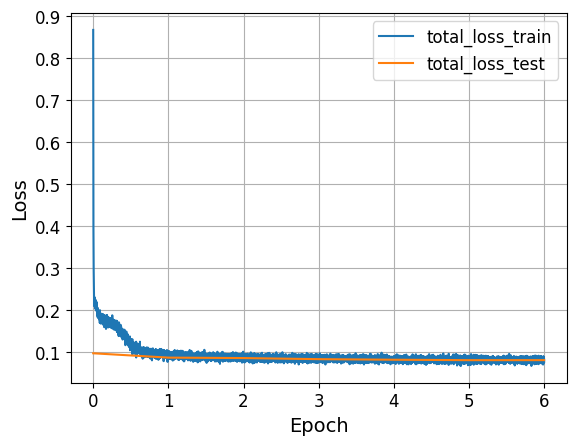

In [ ]:
plot_training_curves(train_losses, test_losses)

Let sample from our model. You probably get better samples than PixelCNN samples.

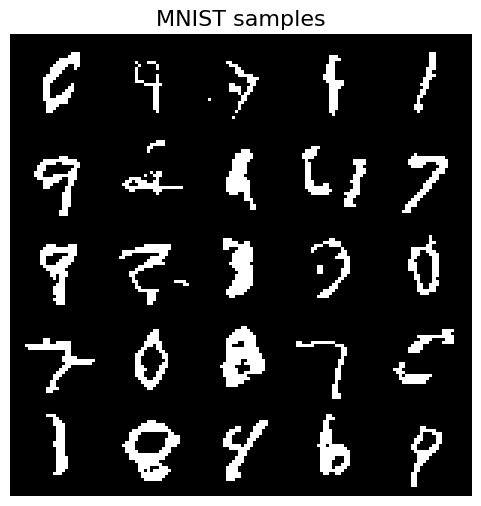

In [ ]:
samples = model.sample(25)
show_samples(samples, title="MNIST samples", nrow=5)